In this notebook I have implemented the most prominent classification algorithms that are in use in machine learning.

I have loaded a dataset using Pandas library, and applied the following algorithms to find the best one for this specific dataset by accuracy evaluation methods.
1. KNN, 2. Logistic Regression, 3. SVM, 4. Decision Trees, 5. Random Forests

Lets first load required libraries:

In [156]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [157]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [158]:
df.shape

(346, 10)

In [159]:
df.effective_date.unique()

array(['9/8/2016', '9/9/2016', '9/10/2016', '9/11/2016', '9/12/2016',
       '9/13/2016', '9/14/2016'], dtype=object)

### Convert to date time object 

In [160]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [161]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [162]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

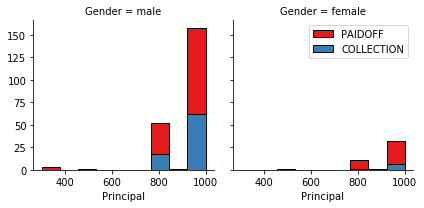

In [163]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

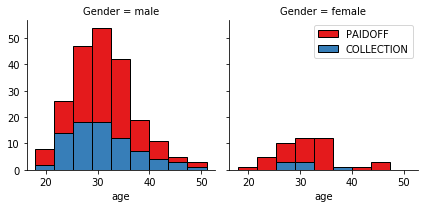

In [164]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

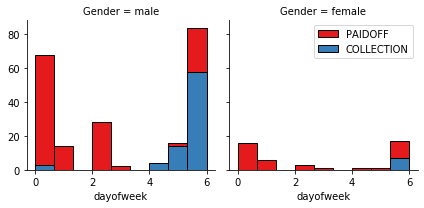

In [165]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [166]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [167]:
df['loan_per_day'] = (df['Principal'] / df['terms']).round(0)
df['loan_per_day'].unique()

array([ 33.,  67.,  53.,  43., 129., 143.,  27., 114.,  60.,  71.])

In [168]:
df['loan_per_day'] = df['loan_per_day'].apply(lambda x: 0 if x<=53 else(1 if (x>53 and x<75) else 2))

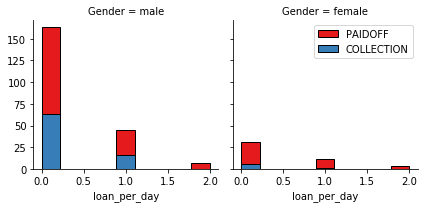

In [169]:
bins = np.linspace(df.loan_per_day.min(), df.loan_per_day.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'loan_per_day', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [170]:
df['loan_tenure'] = df['due_date'] - df['effective_date']

In [171]:
from sklearn.preprocessing import LabelEncoder
label_lt = LabelEncoder()
df['loan_tenure'] = label_lt.fit_transform(df['loan_tenure'])

## Convert Categorical features to numerical values

Lets look at gender:

In [172]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [173]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,loan_per_day,loan_tenure
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,0,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,0,3
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,1,2
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,0,3
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,0,3


## One Hot Encoding  
#### How about education?

In [174]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [175]:
df['education'] = df['education'].apply(lambda x:'Bachelor' if x=='Bechalor' else x)

#### Feature befor One Hot Encoding

In [176]:
df[['Principal','terms','age','Gender','education','loan_tenure','weekend','loan_per_day']].head()

,Principal,terms,age,Gender,education,loan_tenure,weekend,loan_per_day
0,1000,30,45,0,High School or Below,3,0,0
1,1000,30,33,1,Bachelor,3,0,0
2,1000,15,27,0,college,2,0,1
3,1000,30,28,1,college,3,1,0
4,1000,30,29,0,college,3,1,0


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [177]:
Feature = df[['Principal','age','Gender','weekend','loan_tenure']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,age,Gender,weekend,loan_tenure,Bachelor,High School or Below,college
0,1000,45,0,0,3,0,1,0
1,1000,33,1,0,3,1,0,0
2,1000,27,0,0,2,0,0,1
3,1000,28,1,1,3,0,0,1
4,1000,29,0,1,3,0,0,1


### Feature selection

Lets define feature sets, X:

In [178]:
X = Feature
X[0:5]

,Principal,age,Gender,weekend,loan_tenure,Bachelor,High School or Below,college
0,1000,45,0,0,3,0,1,0
1,1000,33,1,0,3,1,0,0
2,1000,27,0,0,2,0,0,1
3,1000,28,1,1,3,0,0,1
4,1000,29,0,1,3,0,0,1


What are our lables?

In [179]:
y = df['loan_status'].apply(lambda x: 0 if x=='COLLECTION' else 1)
y[0:5]

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [180]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
X= stdscaler.fit_transform(X)
X[0:5]

array([[ 0.51578458,  2.33152555, -0.42056004, -1.20577805,  0.51832123,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.34170148,  2.37778177, -1.20577805,  0.51832123,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.65321055, -0.42056004, -1.20577805, -0.6852972 ,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458, -0.48739188,  2.37778177,  0.82934003,  0.51832123,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458, -0.3215732 , -0.42056004,  0.82934003,  0.51832123,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

# K Nearest Neighbor(KNN)

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, f1_score, log_loss, accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Shape of training split:',X_train.shape)
print('Shape of testing split:',X_test.shape)

Shape of training split: (276, 8)
Shape of testing split: (70, 8)


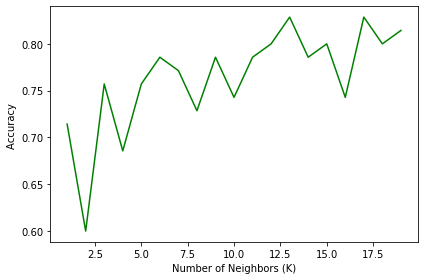

In [182]:
#Finding the optimal value of k by Elbow method:
from sklearn.neighbors import KNeighborsClassifier

Ks = 20
mean_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)

#Plot the accuracy against value of k
plt.plot(range(1,Ks),mean_acc,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [183]:
knn = KNeighborsClassifier(n_neighbors = 12)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_hat))
print('\nClassification Report:\n',classification_report(y_test, y_hat))
print('F1 Score: ', (f1_score(y_test, y_hat)).round(2))
print('Log Loss: ', (log_loss(y_test, y_hat).round(2)))
print('Jaccard Score: ',(jaccard_score(y_test, y_hat)).round(2))

Confusion Matrix:
 [[ 8  4]
 [10 48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.67      0.53        12
           1       0.92      0.83      0.87        58

    accuracy                           0.80        70
   macro avg       0.68      0.75      0.70        70
weighted avg       0.84      0.80      0.81        70

F1 Score:  0.87
Log Loss:  6.91
Jaccard Score:  0.77


In [184]:
Metrics_df = pd.DataFrame(data=None,  index=None, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'])
Metrics_df = pd.concat([Metrics_df,pd.DataFrame([['KNN',jaccard_score(y_test, y_hat).round(2),f1_score(y_test, y_hat).round(2),log_loss(y_test, y_hat).round(2)]], index=None, columns=Metrics_df.columns)], axis=0)
Metrics_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.77,0.87,6.91


# Decision Tree

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Shape of training split:',X_train.shape)
print('Shape of testing split:',X_test.shape)

Shape of training split: (276, 8)
Shape of testing split: (70, 8)


In [186]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=6)
dtree.fit(X_train, y_train)
y_hat = dtree.predict(X_test)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_hat))
print('\nClassification Report:\n',classification_report(y_test, y_hat))
print('F1 Score: ', (f1_score(y_test, y_hat)).round(2))
print('Log Loss: ', (log_loss(y_test, y_hat).round(2)))
print('Jaccard Score: ',(jaccard_score(y_test, y_hat)).round(2))

Confusion Matrix:
 [[ 5  7]
 [ 8 50]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.42      0.40        12
           1       0.88      0.86      0.87        58

    accuracy                           0.79        70
   macro avg       0.63      0.64      0.63        70
weighted avg       0.79      0.79      0.79        70

F1 Score:  0.87
Log Loss:  7.4
Jaccard Score:  0.77


In [187]:
Metrics_df = pd.concat([Metrics_df,pd.DataFrame([['Decision Tree',jaccard_score(y_test, y_hat).round(2),f1_score(y_test, y_hat).round(2),log_loss(y_test, y_hat).round(2)]], index=None, columns=Metrics_df.columns)], axis=0)
Metrics_df.set_index('Algorithm', inplace=True)
Metrics_df

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.77,0.87,6.91
Decision Tree,0.77,0.87,7.40


# Support Vector Machine

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Shape of training split:',X_train.shape)
print('Shape of testing split:',X_test.shape)

Shape of training split: (276, 8)
Shape of testing split: (70, 8)


In [189]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', gamma='scale', C=0.9)
svc.fit(X_train, y_train)
y_hat = svc.predict(X_test)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_hat))
print('\nClassification Report:\n',classification_report(y_test, y_hat))
print('F1 Score: ', (f1_score(y_test, y_hat)).round(2))
print('Log Loss: ', (log_loss(y_test, y_hat).round(2)))
print('Jaccard Score: ',(jaccard_score(y_test, y_hat)).round(2))

Confusion Matrix:
 [[ 3  9]
 [ 8 50]]

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.25      0.26        12
           1       0.85      0.86      0.85        58

    accuracy                           0.76        70
   macro avg       0.56      0.56      0.56        70
weighted avg       0.75      0.76      0.75        70

F1 Score:  0.85
Log Loss:  8.39
Jaccard Score:  0.75


In [190]:
Metrics_df = pd.concat([Metrics_df,pd.DataFrame([[jaccard_score(y_test, y_hat).round(2),f1_score(y_test, y_hat).round(2),log_loss(y_test, y_hat).round(2)]], index=['SVM'], columns=Metrics_df.columns)], axis=0)
Metrics_df

,Jaccard,F1-score,LogLoss
KNN,0.77,0.87,6.91
Decision Tree,0.77,0.87,7.40
SVM,0.75,0.85,8.39


# Logistic Regression

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Shape of training split:',X_train.shape)
print('Shape of testing split:',X_test.shape)

Shape of training split: (276, 8)
Shape of testing split: (70, 8)


In [192]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_hat = logreg.predict(X_test)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_hat))
print('\nClassification Report:\n',classification_report(y_test, y_hat))
print('F1 Score: ', (f1_score(y_test, y_hat)).round(2))
print('Log Loss: ', (log_loss(y_test, y_hat).round(2)))
print('Jaccard Score: ',(jaccard_score(y_test, y_hat)).round(2))

Confusion Matrix:
 [[ 5  7]
 [ 8 50]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.42      0.40        12
           1       0.88      0.86      0.87        58

    accuracy                           0.79        70
   macro avg       0.63      0.64      0.63        70
weighted avg       0.79      0.79      0.79        70

F1 Score:  0.87
Log Loss:  7.4
Jaccard Score:  0.77


In [193]:
Metrics_df = pd.concat([Metrics_df,pd.DataFrame([[jaccard_score(y_test, y_hat).round(2),f1_score(y_test, y_hat).round(2),log_loss(y_test, y_hat).round(2)]], index=['LogisticRegression'], columns=Metrics_df.columns)], axis=0)
Metrics_df

,Jaccard,F1-score,LogLoss
KNN,0.77,0.87,6.91
Decision Tree,0.77,0.87,7.40
SVM,0.75,0.85,8.39
LogisticRegression,0.77,0.87,7.40


# Random Forest

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Shape of training split:',X_train.shape)
print('Shape of testing split:',X_test.shape)

Shape of training split: (276, 8)
Shape of testing split: (70, 8)


In [195]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=5, min_samples_split=2, min_samples_leaf=1)
rfc.fit(X_train, y_train)
y_hat = rfc.predict(X_test)
print('Confusion Matrix:\n',confusion_matrix(y_test, y_hat))
print('\nClassification Report:\n',classification_report(y_test, y_hat))
print('F1 Score: ', (f1_score(y_test, y_hat)).round(2))
print('Log Loss: ', (log_loss(y_test, y_hat).round(2)))
print('Jaccard Score: ',(jaccard_score(y_test, y_hat)).round(2))

Confusion Matrix:
 [[ 1 11]
 [ 0 58]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.84      1.00      0.91        58

    accuracy                           0.84        70
   macro avg       0.92      0.54      0.53        70
weighted avg       0.87      0.84      0.78        70

F1 Score:  0.91
Log Loss:  5.43
Jaccard Score:  0.84


In [196]:
Metrics_df = pd.concat([Metrics_df,pd.DataFrame([[jaccard_score(y_test, y_hat).round(2),f1_score(y_test, y_hat).round(2),log_loss(y_test, y_hat).round(2)]], index=['Random Forests'], columns=Metrics_df.columns)], axis=0)
Metrics_df

,Jaccard,F1-score,LogLoss
KNN,0.77,0.87,6.91
Decision Tree,0.77,0.87,7.40
SVM,0.75,0.85,8.39
LogisticRegression,0.77,0.87,7.40
Random Forests,0.84,0.91,5.43


# Model Evaluation using Test set

In [197]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation 

In [198]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [199]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [200]:
#Preprocessing Test Data --> same way as that of train data
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['loan_per_day'] = (test_df['Principal'] / test_df['terms']).round(0)
test_df['loan_per_day'] = test_df['loan_per_day'].apply(lambda x: 0 if x<=53 else(1 if (x>53 and x<75) else 2))

test_df['loan_tenure'] = test_df['due_date'] - test_df['effective_date']
from sklearn.preprocessing import LabelEncoder
test_df['loan_tenure'] = label_lt.transform(test_df['loan_tenure'])

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_df['education'] = test_df['education'].apply(lambda x:'Bachelor' if x=='Bechalor' else x)
test_feature = test_df[['Principal','age','Gender','weekend','loan_tenure']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,age,Gender,weekend,loan_tenure,Bachelor,High School or Below,college
0,1000,50,1,0,3,1,0,0
1,300,35,0,1,0,0,0,0
2,1000,43,1,1,3,0,1,0
3,1000,26,0,1,3,0,0,1
4,800,29,0,1,2,1,0,0


In [201]:
X_test_data = test_feature
y_truth = test_df['loan_status'].apply(lambda x: 0 if x=='COLLECTION' else 1)
X_test_data = stdscaler.transform(X_test_data)
len(X_test_data)

54

In [202]:
classifiers = [knn,dtree,svc,logreg,rfc]
labels = {'knn':'KNN','dtree':'Decision Tree','svc':'SVM','logreg':'Logistic Regression','rfc':'Random Forests'}
test_metrics = pd.DataFrame(data=None,  index=None, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'])
test_metrics.set_index('Algorithm', inplace=True)
i = 0
for classifier in classifiers:
    y_pred = classifier.predict(X_test_data)
    test_metrics = pd.concat([test_metrics,pd.DataFrame([[jaccard_score(y_truth, y_pred).round(2),f1_score(y_truth, y_pred).round(2),log_loss(y_truth, y_pred).round(2)]], 
                                                        index=[list(labels.values())[i]], columns=test_metrics.columns)], axis=0)
    print('%s confusion matrix:\n' %list(labels.values())[i], confusion_matrix(y_truth, y_pred))
    i += 1

KNN confusion matrix:
 [[ 6  8]
 [ 7 33]]
Decision Tree confusion matrix:
 [[ 3 11]
 [ 6 34]]
SVM confusion matrix:
 [[ 4 10]
 [ 3 37]]
Logistic Regression confusion matrix:
 [[ 4 10]
 [ 3 37]]
Random Forests confusion matrix:
 [[ 0 14]
 [ 1 39]]


# Final Report

In [203]:
test_metrics

,Jaccard,F1-score,LogLoss
KNN,0.69,0.81,9.59
Decision Tree,0.67,0.80,10.87
SVM,0.74,0.85,8.32
Logistic Regression,0.74,0.85,8.32
Random Forests,0.72,0.84,9.59
